# **PROJET BIO-INFO : L'impact de la hausse des températures sur la puissance des ouragans**

# Membres du groupe:

- Anderson TESS
- Fiacre MITOKPE
- Kenny RUFFINE
- Gneneman Stéphane Jean-Baptiste KONÉ 

In [ ]:
pip install folium

In [ ]:
pip install polyfit

In [ ]:
pip install xarray

In [ ]:
pip install netCDF4

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import folium
import requests
from bs4 import BeautifulSoup
import xarray as xr
import tempfile
import os

In [5]:
#Dataset sur les cyclones (certaines lignes ont plus de virgules, c'est pourquoi on "skip" dans les bad_lines)
df2 = pd.read_csv("storms.csv", sep=",", engine="python", on_bad_lines="skip")
df2 = df2.drop(columns=["tropicalstorm_force_diameter", "hurricane_force_diameter", "pressure"]) # colonnes qu'on veut supprimer
df2 = df2[df2["status"] == "hurricane"] # on regarde que les ouragans pour le moment



# On garde que les moments min et max du vent pour chaque ouragan
df2["wind"] = pd.to_numeric(df2["wind"], errors="coerce")


In [6]:
# MAX WIND SPEEDS
df2_max = df2.loc[df2.groupby(["name","year"])["wind"].idxmax()] # on groupe les ouragans par nom, puis on garde le moment ou le vent est au max

# On trie le dataset par annee
df2_max = df2_max.sort_values(by="year", ascending=True) 

# on reset l'index pour faire plus propre
df2_max = df2_max.reset_index(drop=True)

# on affiche le dataset
df2_max

,name,year,month,day,hour,lat,long,status,category,wind
0,Eloise,1975,9,23,12,30.2,-86.3,hurricane,3.0,110
1,Doris,1975,9,2,6,36.4,-44.5,hurricane,2.0,95
2,Caroline,1975,8,31,0,24.0,-97.0,hurricane,3.0,100
3,Faye,1975,9,27,0,32.7,-64.2,hurricane,2.0,90
4,Blanche,1975,7,27,18,37.9,-68.0,hurricane,1.0,75
...,...,...,...,...,...,...,...,...,...,...
314,Fiona,2022,9,21,6,23.5,-71.8,hurricane,4.0,120
315,Martin,2022,11,2,18,36.1,-48.9,hurricane,1.0,75
316,Danielle,2022,9,4,18,38.4,-45.2,hurricane,1.0,75
317,Nicole,2022,11,9,23,26.6,-78.2,hurricane,1.0,65


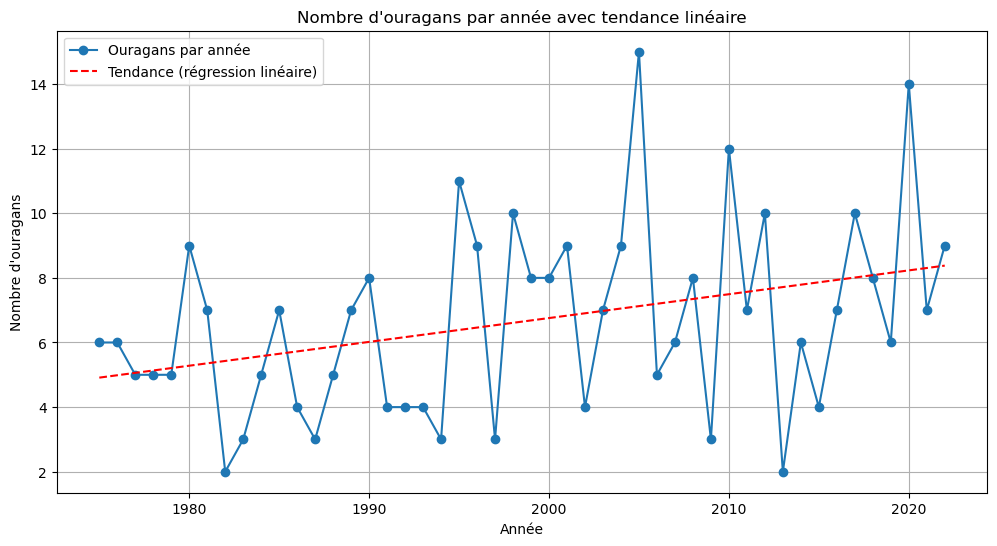

In [7]:
# Comptage du nombre d'ouragans par année
hurricanes_per_year = df2_max["year"].value_counts().sort_index()

# Conversion des données en tableaux numpy
x = hurricanes_per_year.index.values  # Années
y = hurricanes_per_year.values        # Nombre d'ouragans

# Ajustement d'une régression linéaire (droite de tendance)
coeffs = np.polyfit(x, y, 1)  # Degré 1 = droite
linear_trend = np.poly1d(coeffs)  # Crée une fonction polynomiale

# Générer les valeurs prédites pour tracer la droite
x_smooth = np.linspace(x.min(), x.max(), 300)  # Lissage
y_smooth = linear_trend(x_smooth)

# Tracé du graphique
plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o', linestyle='-', label="Ouragans par année")

# Ajout de la droite de tendance
plt.plot(x_smooth, y_smooth, color='red', linestyle='--', label="Tendance (régression linéaire)")

# Ajout des labels et du titre
plt.xlabel("Année")
plt.ylabel("Nombre d'ouragans")
plt.title("Nombre d'ouragans par année avec tendance linéaire")
plt.legend()
plt.grid(True)

# Affichage du graphique
plt.show()

In [8]:

# MIN WIND SPEEDS
df2_min = df2.loc[df2.groupby(["name","year"])["wind"].idxmin()] # on groupe les ouragans par nom, puis on garde le moment ou le vent est au max

# On trie le dataset par annee
df2_min = df2_min.sort_values(by="year", ascending=True) 

# on reset l'index pour faire plus propre
df2_min = df2_min.reset_index(drop=True)

# on affiche le dataset
df2_min


,name,year,month,day,hour,lat,long,status,category,wind
0,Eloise,1975,9,16,18,19.5,-68.4,hurricane,1.0,65
1,Doris,1975,8,31,0,34.9,-46.3,hurricane,1.0,65
2,Caroline,1975,8,30,0,23.3,-94.2,hurricane,1.0,65
3,Faye,1975,9,26,0,26.5,-60.0,hurricane,1.0,65
4,Blanche,1975,7,27,6,35.9,-70.0,hurricane,1.0,65
...,...,...,...,...,...,...,...,...,...,...
314,Fiona,2022,9,18,12,17.2,-66.2,hurricane,1.0,65
315,Martin,2022,11,2,12,35.1,-50.9,hurricane,1.0,65
316,Danielle,2022,9,2,12,37.8,-43.6,hurricane,1.0,65
317,Nicole,2022,11,9,23,26.6,-78.2,hurricane,1.0,65


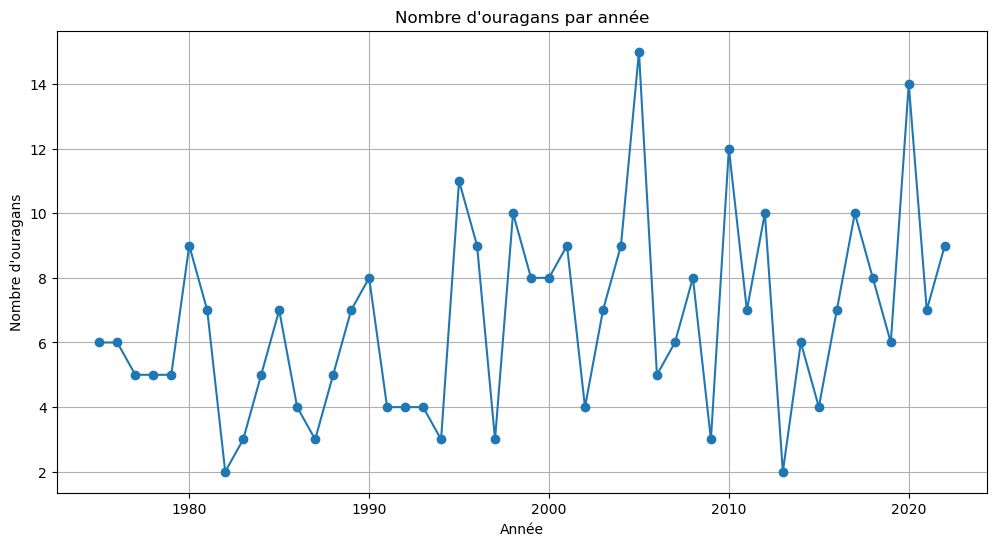

In [9]:
# Comptage du nombre d'ouragans par année
hurricanes_per_year = df2_min["year"].value_counts().sort_index()

# Tracé du graphique
plt.figure(figsize=(12, 6))
plt.plot(hurricanes_per_year.index, hurricanes_per_year.values, marker='o', linestyle='-')
plt.xlabel("Année")
plt.ylabel("Nombre d'ouragans")
plt.title("Nombre d'ouragans par année")
plt.grid(True)
plt.show()

In [10]:

def get_hurricane_year_by_index(df, index):
    """
    retourne une seule ligne du dataset en fonction de l'indice donné en paramètre.

    Paramètres:
    df (DataFrame): dataset des ouragans.
    index (int): indice de la ligne à recupérer.

    Returns:
    str : Une str Pandas contenant l'année, le mois, le jour, la latitude, la longitude et la catégorie, 
            ou un message d'erreur si l'index dépasse la taille du dataset.
    """

    required_columns = {"year"}

    if not required_columns.issubset(df.columns):
        return "Error: The dataset does not contain all the required columns."

    if index < 0 or index >= len(df):
        return "Error: Index out of range."

    return int(df.loc[index, ["year"]])

print("\n")
index = 43 #1982 
index2 = 102 #1995 
index3 = 162 #2002
index4 = 190 #2005 
index5 = 228 #2010 
index6 = 247 #2013 
index7 = 300 #2020 
hurricane_year1 = get_hurricane_year_by_index(df2_max, index)
hurricane_year2 = get_hurricane_year_by_index(df2_max, index2)
hurricane_year3 = get_hurricane_year_by_index(df2_max, index3)
hurricane_year4 = get_hurricane_year_by_index(df2_max, index4)
hurricane_year5 = get_hurricane_year_by_index(df2_max, index5)
hurricane_year6 = get_hurricane_year_by_index(df2_max, index5)
hurricane_year7 = get_hurricane_year_by_index(df2_max, index7)
print(hurricane_year1)
print("\n")
print(hurricane_year2)
print("\n")
print(hurricane_year3)
print("\n")
print(hurricane_year4)
print("\n")
print(hurricane_year5)
print("\n")
print(hurricane_year6)
print("\n")
print(hurricane_year7)
print("\n")






1982


1995


2002


2005


2010


2010


2020




/var/folders/pl/7s2_jcw90m53zlgw891lk92m0000gn/T/ipykernel_32386/3556930609.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(df.loc[index, ["year"]])
/var/folders/pl/7s2_jcw90m53zlgw891lk92m0000gn/T/ipykernel_32386/3556930609.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(df.loc[index, ["year"]])
/var/folders/pl/7s2_jcw90m53zlgw891lk92m0000gn/T/ipykernel_32386/3556930609.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(df.loc[index, ["year"]])
/var/folders/pl/7s2_jcw90m53zlgw891lk92m0000gn/T/ipykernel_32386/3556930609.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instea

In [11]:


def plot_hurricane_on_map_with_category(df):
    """
    Affiche les positions des cyclones (latitude, longitude) sur une carte interactive avec une icône
    correspondant à la catégorie de chaque ouragan.
    
    Parameters:
    df (DataFrame): Le dataset des cyclones avec des colonnes 'lat', 'long' et 'category'.
    
    Returns:
    folium.Map: Carte interactive affichant les cyclones avec des icônes basées sur leur catégorie.
    """
    # Créer une carte centrée autour d'un point par défaut (ici, centre de l'océan Atlantique)
    hurricane_map = folium.Map(location=[20, -50], zoom_start=3)

    # Vérifier que les colonnes nécessaires existent dans le DataFrame
    if 'lat' in df.columns and 'long' in df.columns and 'category' in df.columns:
        # Dictionnaire pour associer une couleur à chaque catégorie
        category_colors = {
            1: 'blue',     # Catégorie 1 
            2: 'green',    # Catégorie 2
            3: 'orange',   # Catégorie 3 
            4: 'red',   # Catégorie 4 
            5: 'black'       # Catégorie 5  
        }
        
        # Ajouter un marqueur pour chaque cyclone en fonction de la latitude et la longitude)
        for index, row in df.iterrows():
            category = row['category']
            color = category_colors.get(category, 'gray')  # Utiliser 'gray' par défaut si la catégorie est inconnue
            
            folium.Marker(
                location=[row['lat'], row['long']],
                popup=f"Name : {row['name']}, Year: {row['year']}, Month: {row['month']}, Day: {row['day']}, Category: {category}",
                icon=folium.Icon(color=color, icon='info-sign')
            ).add_to(hurricane_map)
    else:
        print("Erreur : Les colonnes 'lat', 'long' et 'category' sont nécessaires dans le DataFrame.")
    
    
    return hurricane_map


hurricane_map = plot_hurricane_on_map_with_category(df2_max)
hurricane_map



    

In [16]:
# La fonction pour afficher l'évolution de la forces des vents
# Pour chaque année, on calcule la moyenne de la force des vents max
mean_of_max_wind_per_year = df2_max.groupby('year')['wind'].mean().reset_index()
mean_of_max_wind_per_year

# Pour chaque année, on calcule la moyenne de la force des vents min
mean_of_min_wind_per_year = df2_min.groupby('year')['wind'].mean().reset_index()
mean_of_min_wind_per_year


,year,wind
0,1975,65.000000
1,1976,65.833333
2,1977,65.000000
3,1978,66.000000
4,1979,65.000000
5,1980,65.000000
6,1981,66.428571
7,1982,65.000000
8,1983,65.000000
9,1984,65.000000


In [26]:

def affichage_moy_vents(name):
    # Conversion des données en tableau numpy
    xMax = mean_of_max_wind_per_year['year']  # Années
    yMax = mean_of_max_wind_per_year['wind']  # Vent
    
    # ajustement d'une régression linéaire (droite de tendance)
    coeffs = np.polyfit(xMax, yMax, 1)  # Degré 1 = droite
    linear_trend = np.poly1d(coeffs)  # Crée une fonction polynomiale
    
    # générer les valeurs prédites pour tracer la droite
    x_smooth = np.linspace(xMax.min(), xMax.max(), 300)  # Lissage
    y_smooth = linear_trend(x_smooth)
    
    # tracé du graphique
    plt.figure(figsize=(12, 6))
    plt.plot(xMax, yMax, marker='o', linestyle='-', label="Ouragans par année")
    
    
    plt.plot(x_smooth, y_smooth, color='red', linestyle='--', label="Tendance (régression linéaire)")
    
    
    plt.xlabel("Année")
    plt.ylabel("Vitesse moyenne des vents(Km/h)")
    plt.legend()
    plt.title("Évolution moyenne des vents maximums par année avec tendance linéaire")
    plt.grid(True)

    # Affichage du graphique
    plt.show()


In [14]:
#La fonction pour afficher l'évolution de la catégorie des ouragans
##Pour chaque année, on calcule la moyenne de la catégorie des ouragans
mean_of_category_per_year = df2.groupby('year')['category'].mean().reset_index()
mean_of_category_per_year

,year,category
0,1975,1.487805
1,1976,1.480769
2,1977,1.576923
3,1978,1.906977
4,1979,2.000000
5,1980,1.928105
6,1981,1.644444
7,1982,1.869565
8,1983,1.375000
9,1984,1.270270


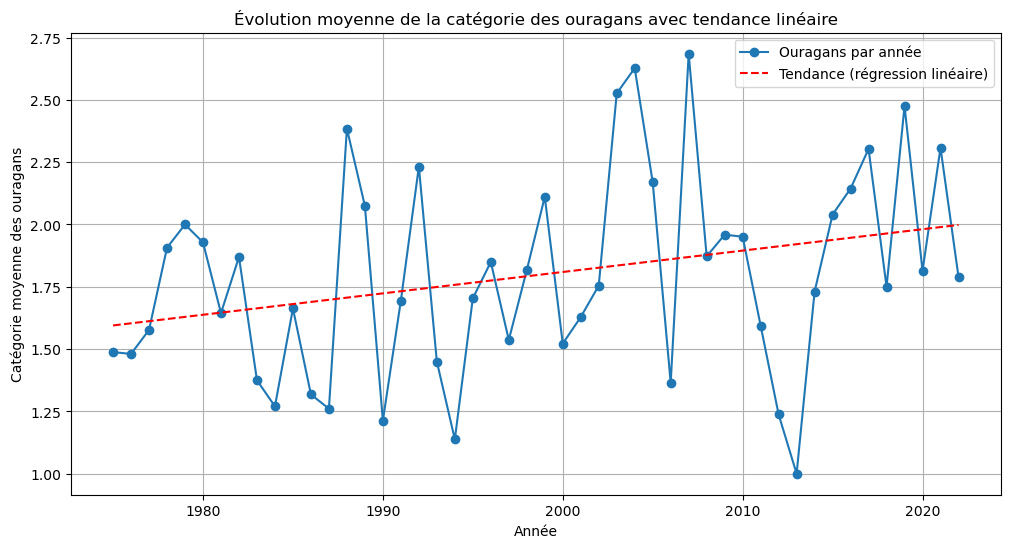

In [15]:

def affiche_moy_cat(df):
    #conversion des données en tableaux numpy
    x = mean_of_category_per_year['year']  # Années
    y = mean_of_category_per_year['category']        # Vent
    
    #ajustement d'une régression linéaire (droite de tendance)
    coeffs = np.polyfit(x, y, 1)  # Degré 1 = droite
    linear_trend = np.poly1d(coeffs)  # Crée une fonction polynomiale
    
    #générer les valeurs prédites pour tracer la droite
    x_smooth = np.linspace(x.min(), x.max(), 300)  # Lissage
    y_smooth = linear_trend(x_smooth)
    
    #tracé du graphique
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, marker='o', linestyle='-', label="Ouragans par année")
    
    #droite de tendance
    plt.plot(x_smooth, y_smooth, color='red', linestyle='--', label="Tendance (régression linéaire)")
    
    plt.xlabel("Année")
    plt.ylabel("Catégorie moyenne des ouragans")
    plt.legend()
    plt.title("Évolution moyenne de la catégorie des ouragans avec tendance linéaire")
    plt.grid(True)
    

    plt.show()

affiche_moy_cat(mean_of_category_per_year)

In [ ]:
pip install openpyxl

In [ ]:
import pandas as pd

# Charger ton dataframe créé avec des données récueillies grâce à gpt
df_sans = pd.read_excel('coordonnees_atlantique_nord.xlsx')
df_sans

In [ ]:
df_sans.dtypes

In [ ]:
df2_copy = df2
df2_copy

In [ ]:
df_sans['year'] = df_sans['Date'].dt.year
df_sans['month'] = df_sans['Date'].dt.month
df_sans['day'] = df_sans['Date'].dt.day
df_sans['ouragan'] = 0
df2_copy['ouragan'] = 1
df_sans = df_sans.drop(columns=["Date"])
df_sans

In [ ]:
df_sans.columns

In [ ]:
df_sans[['year', 'month', 'day', 'ouragan']] = df_sans[['year', 'month', 'day', 'ouragan']].astype(int)
df_sans[['lat', 'long']] = df_sans[['lat', 'long']].astype(float)

In [ ]:
all_rows = pd.merge(df2_copy, df_sans, on=['lat', 'long', 'year', 'month', 'day'], how='outer')
all_rows

In [ ]:
print(df2_copy.dtypes)
print(df_sans.dtypes)

In [ ]:
from sklearn.utils import resample

# Suréchantillonnage des "sans ouragan"
df_no_hurricane_resampled = resample(df_sans, 
                                     replace=True,  # Permet de réutiliser les mêmes lignes
                                     n_samples=4000,  # On veut 4000 lignes
                                     random_state=42)  # Pour la reproductibilité

# Fusionner le tout
df_balanced = pd.concat([df2_copy, df_no_hurricane_resampled])

# Vérifier le nombre d'observations par classe
print(df_balanced['ouragan'].value_counts())

In [ ]:
df_no_hurricane_resampled

Vu qu'on a suréchantilloné, faudra penser à vérifier que les valeurs lignes crées n'existent pas dans df2_copy (ouragan1)

In [ ]:
df_balanced

On vérifie que les lignes lat, long, year, month et day sont uniques car vu qu’on a suréchantilloné il se pourrait qu’il y ait des lignes avec les mêmes coordonnées et périodes (non ouragans) qui correspondent exactement à des lignes (ouragans)

Je n'ai pas encore réussi à le faire 

In [ ]:
# Vérifier si toutes les combinaisons des colonnes 'lat', 'long', 'year', 'day', 'month' sont uniques
duplicates = df_no_hurricane_resampled[['lat', 'long', 'year', 'day', 'month']].duplicated()

# Afficher les lignes qui sont en doublon
df_no_hurricane_resampled[duplicates]

# Compter combien de doublons existent
print(f"Nombre de doublons : {duplicates.sum()}")

# Vérifier si toutes les combinaisons sont uniques
if duplicates.sum() == 0:
    print("Toutes les lignes des colonnes 'lat', 'long', 'year', 'day', 'month' sont uniques.")
else:
    print("Il y a des doublons dans les colonnes 'lat', 'long', 'year', 'day', 'month'.")

In [ ]:
dd = df_no_hurricane_resampled[duplicates]
dd

In [ ]:
# Filtrer les lignes correspondant à year=1998, month=9, day=28, lat=12.0, long=30.4
filtered_df = dd[(dd['year'] == 2017) & 
                 (dd['month'] == 4) & 
                 (dd['day'] == 14) & 
                 (dd['lat'] == 50.5) & 
                 (dd['long'] == -38.5)]

# Afficher les lignes filtrées
filtered_df

In [ ]:
# Vérifier si toutes les colonnes de la ligne sont dupliquées
duplicates = df_balanced.duplicated(subset=['lat', 'long', 'year', 'day', 'month'])

# Afficher les lignes qui sont en doublon (avec toutes les colonnes)
print(df_balanced[duplicates])

# Compter combien de doublons existent
print(f"Nombre de doublons : {duplicates.sum()}")

# Vérifier si toutes les combinaisons des colonnes sont uniques
if duplicates.sum() == 0:
    print("Toutes les lignes des colonnes 'lat', 'long', 'year', 'day', 'month' sont uniques.")
else:
    print("Il y a des doublons dans les colonnes 'lat', 'long', 'year', 'day', 'month'.")

In [ ]:
# Trouver les lignes avec exactement les mêmes valeurs sur toutes les colonnes
exact_duplicates = df_balanced[df_balanced.duplicated(subset=['lat', 'long', 'year', 'month', 'day'], keep=False)]

# Afficher ces doublons exacts
exact_duplicates

In [ ]:
#Dataset sur les cyclones (certaines lignes ont plus de virgules, c'est pourquoi on "skip" dans les bad_lines)
df2 = pd.read_csv("storms.csv", sep=",", engine="python", on_bad_lines="skip")
df2 = df2.drop(columns=["tropicalstorm_force_diameter", "hurricane_force_diameter"]) # colonnes qu'on veut supprimer
df2 = df2[df2["status"] == "hurricane"] # on regarde que les ouragans pour le moment

# On garde que les moments min et max du vent pour chaque ouragan
df2["wind"] = pd.to_numeric(df2["wind"], errors="coerce")

# MAX WIND SPEEDS
df2_max = df2.loc[df2.groupby("name")["wind"].idxmax()] # on groupe les ouragans par nom, puis on garde le moment ou le vent est au max

# On trie le dataset par annee
df2_max = df2_max.sort_values(by="year", ascending=True) 

# on reset l'index pour faire plus propre
df2_max = df2_max.reset_index(drop=True)

# on affiche le dataset
df2_max

In [ ]:

# MIN WIND SPEEDS
df2_min = df2.loc[df2.groupby("name")["wind"].idxmin()] # on groupe les ouragans par nom, puis on garde le moment ou le vent est au max

# On trie le dataset par annee
df2_min = df2_min.sort_values(by="year", ascending=True) 

# on reset l'index pour faire plus propre
df2_min = df2_min.reset_index(drop=True)

# on affiche le dataset
df2_min


In [ ]:
# Générer une plage de températures de la mer allant de 20°C à 30°C
temperatures = np.linspace(20, 30, 500)

# On considère que pour T < 26.5°C, le risque est faible (0)
# et pour T >= 26.5°C, le risque devient élevé (1)
risque = np.where(temperatures >= 26.5, 1, 0)

# Création de la figure
plt.figure(figsize=(10, 6))

# Tracé de la courbe du risque en fonction de la température
plt.plot(temperatures, risque, label="Risque d'ouragan", color='blue')

# Ajout d'une ligne verticale pour marquer le seuil critique de 26.5°C
plt.axvline(26.5, color='red', linestyle='--', label="Seuil critique: 26.5°C")

# Étiquettes et titre
plt.xlabel("Température de la mer (°C)")
plt.ylabel("Risque d'ouragan (0 = faible, 1 = élevé)")
plt.title("Impact de la température de la mer sur le risque d'ouragan")

# Affichage de la légende et de la grille
plt.legend()
plt.grid(True)

# Affichage du graphique
plt.show()

In [ ]:

def verify_files():
    # Vérification du fichier CSV
    csv_file = "storms.csv"
    if os.path.exists(csv_file):
        print(f"Le fichier CSV '{csv_file}' a été trouvé.")
        # Affichage rapide des premières lignes
        df = pd.read_csv(csv_file)
        print("Aperçu du fichier CSV :")
        print(df.head())
    else:
        print(f"Le fichier CSV '{csv_file}' n'a pas été trouvé.")
    
    # Vérification du fichier NetCDF pour 1981
    nc_file = "sst.day.mean.2002.nc"
    if os.path.exists(nc_file):
        print(f"\nLe fichier NetCDF '{nc_file}' a été trouvé.")
        ds = xr.open_dataset(nc_file)
        print("Variables disponibles dans le fichier NetCDF :", list(ds.data_vars))
        print("Coordonnées disponibles :", list(ds.coords))
    else:
        print(f"Le fichier NetCDF '{nc_file}' n'a pas été trouvé.")

if __name__ == "__main__":
    verify_files()


In [ ]:

def get_sst_for_year(year):
    """
    Pour une année donnée, cette fonction lit le fichier CSV des tempêtes et le fichier
    NetCDF des moyennes journalières de température de surface (SST) correspondant à cette année.
    
    Pour chaque événement de tempête de l'année (défini par la colonne 'year' du CSV),
    elle crée une date en combinant les colonnes 'year', 'month' et 'day' et récupère la température de l'eau
    (variable 'sst') à l'aide des coordonnées (lat, long) de l'événement.
    
    Paramètres:
        year (int): L'année à analyser.
        
    Retour:
        pd.DataFrame: Le DataFrame des tempêtes de l'année avec une colonne supplémentaire 'sst'
                      indiquant la température de l'eau au moment et à l'emplacement de l'événement.
    """
    # Lecture du fichier CSV des tempêtes
    storms = pd.read_csv("storms.csv")
    
    # Création d'une colonne datetime à partir des colonnes 'year', 'month', 'day'
    # (le champ 'hour' est omis ici car le NetCDF contient des moyennes journalières)
    storms["datetime"] = pd.to_datetime(storms[["year", "month", "day"]])
    
    # Filtrer les événements pour l'année spécifiée
    storms_year = storms[storms["year"] == year].copy()
    
    # Construction du nom du fichier NetCDF
    nc_file = f"sst.day.mean.{year}.nc"
    
    # Ouverture du fichier NetCDF avec xarray
    ds = xr.open_dataset(nc_file)
    
    # Liste pour stocker les valeurs de SST pour chaque événement
    sst_values = []
    
    # Pour chaque événement, récupération de la température (variable 'sst') 
    # en utilisant la méthode 'nearest' pour sélectionner la valeur la plus proche selon la date et les coordonnées
    for idx, row in storms_year.iterrows():
        event_date = row["datetime"]
        event_lat = row["lat"]
        event_lon = row["long"]  # la colonne s'appelle 'long' dans le CSV et 'lon' dans le NetCDF
        try:
            sst_val = ds["sst"].sel(time=event_date, lat=event_lat, lon=event_lon, method="nearest").values.item()
        except Exception as e:
            # Si la sélection échoue (par exemple, si l'événement est en dehors du domaine du NetCDF), retourner None
            sst_val = None
        sst_values.append(sst_val)
    
    # Ajout de la colonne 'sst' dans le DataFrame des tempêtes
    storms_year["sst"] = sst_values
    
    return storms_year

# Exemple d'utilisation
if __name__ == "__main__":
    annee = 1981  # Remplacer par l'année souhaitée
    result_df = get_sst_for_year(annee)
    print(result_df.head())


In [ ]:
def get_sst_for_year(year):
    """
    Pour une année donnée, cette fonction lit le fichier CSV des tempêtes et le fichier
    NetCDF des moyennes journalières de température de surface (SST) correspondant à cette année.
    
    Pour chaque événement de tempête de l'année (défini par la colonne 'year' du CSV),
    elle crée une date en combinant les colonnes 'year', 'month' et 'day' et récupère la température de l'eau
    (variable 'sst') en utilisant les coordonnées (lat, long) de l'événement.
    
    Paramètres:
        year (int): L'année à analyser.
        
    Retour:
        pd.DataFrame: Le DataFrame des tempêtes de l'année avec une colonne supplémentaire 'sst'
                      indiquant la température de l'eau au moment et à l'emplacement de l'événement.
    """
    # Lecture du fichier CSV des tempêtes
    storms = pd.read_csv("storms.csv")
    
    # Création d'une colonne datetime à partir des colonnes 'year', 'month', 'day'
    storms["datetime"] = pd.to_datetime(storms[["year", "month", "day"]])
    
    # Filtrer les événements pour l'année spécifiée
    storms_year = storms[storms["year"] == year].copy()
    
    # Construction du nom du fichier NetCDF
    nc_file = f"sst.day.mean.{year}.nc"
    
    # Ouverture du fichier NetCDF avec xarray
    ds = xr.open_dataset(nc_file)
    
    # Liste pour stocker les valeurs de SST pour chaque événement
    sst_values = []
    
    # Pour chaque événement, récupération de la température (variable 'sst')
    # en utilisant la méthode 'nearest' pour sélectionner la valeur la plus proche selon la date et les coordonnées
    for idx, row in storms_year.iterrows():
        event_date = row["datetime"]
        event_lat = row["lat"]
        event_lon = row["long"]  # dans le CSV la colonne s'appelle 'long' et dans le NetCDF 'lon'
        try:
            sst_val = ds["sst"].sel(time=event_date, lat=event_lat, lon=event_lon, method="nearest").values.item()
        except Exception as e:
            sst_val = None
        sst_values.append(sst_val)
    
    # Ajout de la colonne 'sst' dans le DataFrame
    storms_year["sst"] = sst_values
    
    return storms_year

def plot_sst_for_year(year):
    """
    Pour une année donnée, cette fonction récupère les données de tempête avec leur SST associée
    et affiche un graphique avec la date sur l'axe x et la température (SST) sur l'axe y.
    """
    # Récupération des données
    df = get_sst_for_year(year)
    
    # On élimine les événements sans donnée SST
    df = df[df['sst'].notnull()]
    
    # Création du graphique
    plt.figure(figsize=(12, 6))
    plt.scatter(df['datetime'], df['sst'], color='blue', label='Température SST')
    plt.xlabel("Date")
    plt.ylabel("Température de surface de la mer (SST)")
    plt.title(f"Température de surface de la mer lors des ouragans en {year}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemple d'utilisation
if __name__ == "__main__":
    annee =hurricane_year3  # Remplacer par l'année souhaitée
    plot_sst_for_year(annee)